# **Projet : Pr√©vision de consommation d'√©l√©ctricit√©**

Partie 3 : Application des mod√®les de pr√©vision



1.   Holt-Winters
2.   SARIMA
3.   SARIMAX


<h2>Rappel des mod√®les utilis√©s</h2>

<h3>1. Holt-Winters additif</h3>
<p><strong>Composantes :</strong> niveau (L<sub>t</sub>), tendance (T<sub>t</sub>), saisonnalit√© (S<sub>t</sub>)</p>
<p><strong>Formules :</strong></p>
<ul>
  <li>L<sub>t</sub> = Œ± (Y<sub>t</sub> - S<sub>t-m</sub>) + (1-Œ±)(L<sub>t-1</sub> + T<sub>t-1</sub>)</li>
  <li>T<sub>t</sub> = Œ≤ (L<sub>t</sub> - L<sub>t-1</sub>) + (1-Œ≤) T<sub>t-1</sub></li>
  <li>S<sub>t</sub> = Œ≥ (Y<sub>t</sub> - L<sub>t</sub>) + (1-Œ≥) S<sub>t-m</sub></li>
  <li>≈∂<sub>t+h</sub> = L<sub>t</sub> + h T<sub>t</sub> + S<sub>t-m+h<sub>m</sub></sub>, o√π h<sub>m</sub> = ((h-1) mod m) + 1</li>
</ul>
<p><strong>Param√®tres :</strong></p>
<ul>
  <li>Y<sub>t</sub> : observation r√©elle √† l‚Äôinstant t</li>
  <li>m : p√©riode saisonni√®re</li>
  <li>Œ±, Œ≤, Œ≥ : coefficients de lissage (niveau, tendance, saisonnalit√©)</li>
</ul>

<h3>2. SARIMA (Seasonal ARIMA)</h3>
<p><strong>Notation :</strong> SARIMA(p,d,q) √ó (P,D,Q)<sub>m</sub></p>
<p><strong>Formule g√©n√©rale :</strong></p>
<p>Œ¶<sub>P</sub>(B<sup>m</sup>) œÜ<sub>p</sub>(B) ‚àá<sup>d</sup> ‚àá<sup>D</sup><sub>m</sub> Y<sub>t</sub> = Œò<sub>Q</sub>(B<sup>m</sup>) Œ∏<sub>q</sub>(B) Œµ<sub>t</sub></p>
<ul>
  <li>B : op√©rateur retard (B Y<sub>t</sub> = Y<sub>t-1</sub>)</li>
  <li>œÜ<sub>p</sub>(B), Œ∏<sub>q</sub>(B) : polyn√¥mes AR et MA</li>
  <li>Œ¶<sub>P</sub>(B<sup>m</sup>), Œò<sub>Q</sub>(B<sup>m</sup>) : polyn√¥mes saisonniers AR et MA</li>
  <li>‚àá<sup>d</sup> = (1-B)<sup>d</sup> : diff√©renciation non saisonni√®re</li>
  <li>‚àá<sup>D</sup><sub>m</sub> = (1-B<sup>m</sup>)<sup>D</sup> : diff√©renciation saisonni√®re</li>
  <li>Œµ<sub>t</sub> : terme d‚Äôerreur blanc</li>
</ul>

<h3>3. SARIMAX (SARIMA avec variables exog√®nes)</h3>
<p><strong>Formule :</strong></p>
<p>Y<sub>t</sub> = SARIMA(p,d,q)(P,D,Q)<sub>m</sub> + X<sub>t</sub> Œ≤ + Œµ<sub>t</sub></p>
<ul>
  <li>X<sub>t</sub> : vecteur des variables exog√®nes (ex. temp√©rature, DJU)</li>
  <li>Œ≤ : coefficients associ√©s aux variables exog√®nes</li>
  <li>Le reste est identique √† SARIMA pour la composante temporelle</li>
</ul>

 


In [73]:
# Importer les biblioth√®ques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import itertools
import statsmodels.api as sm




# √âtapes pour appliquer le mod√®le Holt-Winters additif

1. **Importer et visualiser la s√©rie temporelle**  
   - Charger les donn√©es et tracer la s√©rie pour observer tendances et saisonnalit√©s.

2. **(Optionnel mais recommand√©) D√©composer la s√©rie**  
   - Identifier les composantes : tendance, saisonnalit√©, r√©sidus.  
   - V√©rifier si la saisonnalit√© est constante (adapt√© au mod√®le additif).

3. **Ajuster le mod√®le Holt-Winters additif**  
   - D√©finir `trend="add"`, `seasonal="add"`, et `seasonal_periods`.

4. **V√©rifier l‚Äôajustement du mod√®le**  
   - Comparer la courbe r√©elle avec la courbe pr√©dite.

5. **Pr√©voir le futur (forecast)**  
   - G√©n√©rer les pr√©visions pour les pas de temps souhait√©s.

6. **√âvaluer les performances du mod√®le**  
   - Calculer des m√©triques comme MAE, RMSE, AIC.

7. **Analyser les r√©sidus**  
   - V√©rifier l‚Äôabsence de tendance, d‚Äôautocorr√©lation et de motifs saisonniers non captur√©s.


In [33]:
df = pd.read_csv('df_corrig√©.csv')
df

Mois  Consommation totale  dju_chauffage    conso_corr
0   2012-01-01                51086          336.0  43259.231509
1   2012-02-01                54476          435.9  41804.889062
2   2012-03-01                43156          201.9  41831.997497
3   2012-04-01                40176          230.3  37474.827072
4   2012-05-01                35257           83.3  39684.138781
..         ...                  ...            ...           ...
79  2018-08-01                32451            3.3  40757.492092
80  2018-09-01                32683           34.3  39486.242684
81  2018-10-01                37102          122.4  39633.104850
82  2018-11-01                43738          282.5  38505.549036
83  2018-12-01                47553          325.9  40215.999865

[84 rows x 4 columns]

In [34]:
df.set_index('Mois' , inplace = True)

df.index = pd.to_datetime(df.index)

In [35]:
df=df.drop(columns='Consommation totale')
df

dju_chauffage    conso_corr
Mois                                   
2012-01-01          336.0  43259.231509
2012-02-01          435.9  41804.889062
2012-03-01          201.9  41831.997497
2012-04-01          230.3  37474.827072
2012-05-01           83.3  39684.138781
...                   ...           ...
2018-08-01            3.3  40757.492092
2018-09-01           34.3  39486.242684
2018-10-01          122.4  39633.104850
2018-11-01          282.5  38505.549036
2018-12-01          325.9  40215.999865

[84 rows x 2 columns]

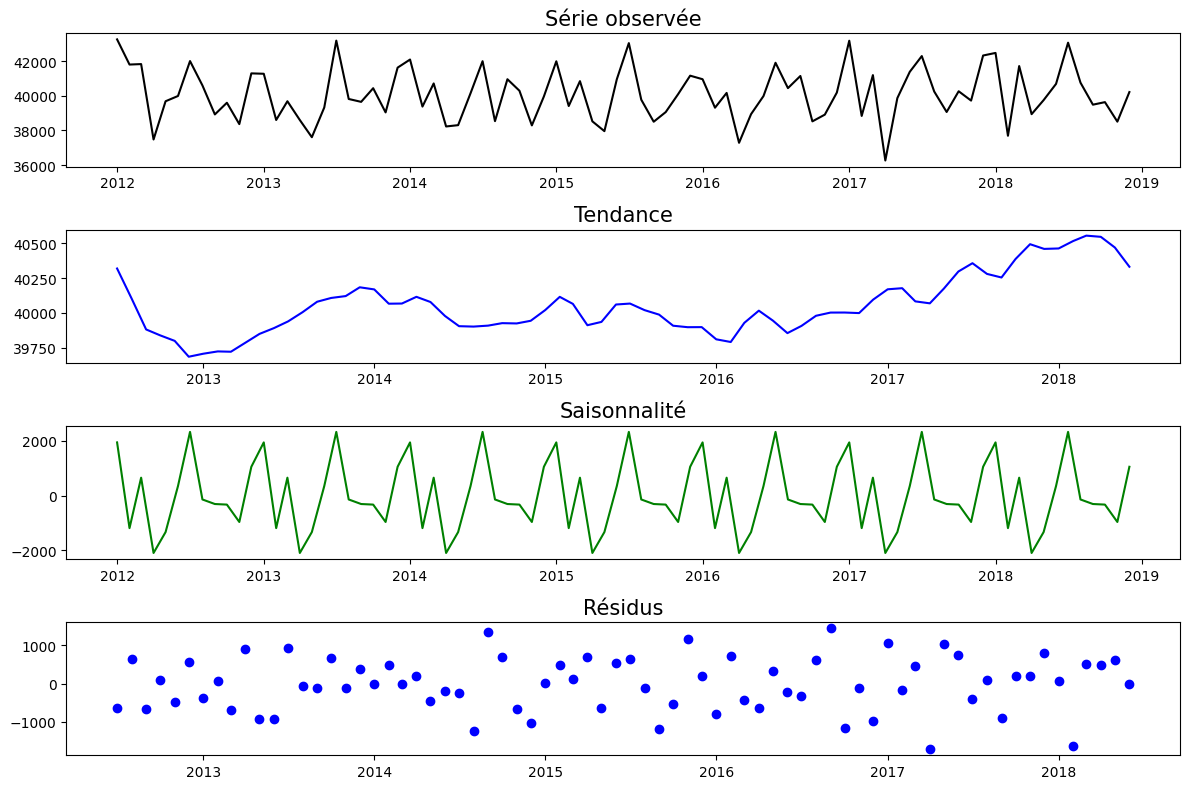

In [36]:
#1.	D√©composer la s√©rie : en tandance ,saisonalit√© et r√©sidue



decomposition = seasonal_decompose(df['conso_corr'], model='additive')

# Cr√©ation de la figure
fig, ax = plt.subplots(4, 1, figsize=(12, 8))

ax[0].plot(decomposition.observed, color='black')
ax[0].set_title('S√©rie observ√©e', fontsize=15)

ax[1].plot(decomposition.trend, color='blue')
ax[1].set_title('Tendance', fontsize=15)

ax[2].plot(decomposition.seasonal, color='green')
ax[2].set_title('Saisonnalit√©', fontsize=15)

ax[3].plot(decomposition.resid, 'bo')
ax[3].set_title('R√©sidus', fontsize=15)

plt.tight_layout()

plt.show()

In [37]:
y = df['conso_corr']
train_size = len(y) - 12
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print("Train size:", len(y_train), "Test size:", len(y_test))

Train size: 72 Test size: 12


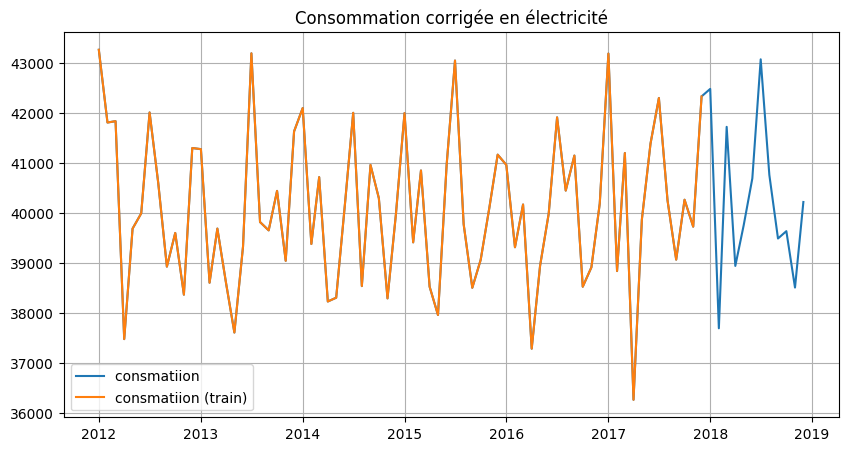

In [38]:
plt.figure(figsize=(10,5))
y=df["conso_corr"]
plt.plot(y, label="consmatiion ")
plt.plot(y_train, label="consmatiion (train)")
plt.title("Consommation corrig√©e en √©lectricit√©")
plt.legend()
plt.grid(True)
plt.show()

In [39]:

model_hw=ExponentialSmoothing(
    y_train,
    trend="add",
    seasonal="add",
    seasonal_periods=12
)

fit_hw = model_hw.fit(optimized=True)
print(fit_hw.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:               conso_corr   No. Observations:                   72
Model:             ExponentialSmoothing   SSE                       45179854.675
Optimized:                         True   AIC                            993.164
Trend:                         Additive   BIC                           1029.590
Seasonal:                      Additive   AICC                          1006.069
Seasonal Periods:                    12   Date:                 Tue, 16 Sep 2025
Box-Cox:                          False   Time:                         16:20:31
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level              1.4901e-08                alpha                 True
smoothing_trend          

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


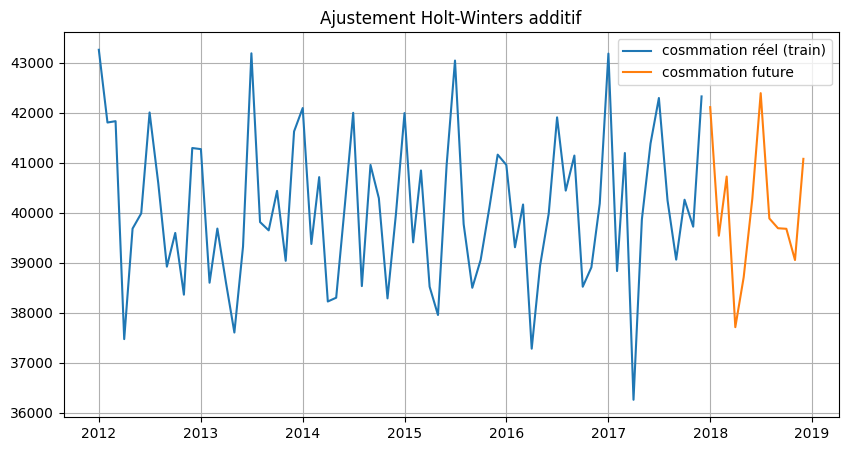

In [40]:
#Pr√©visions futures
# Pr√©voir les 12 prochains mois
y_pred_hw = fit_hw.forecast(len(y_test))

plt.figure(figsize=(10,5))
plt.plot(y_train , label="cosmmation r√©el (train)")
plt.plot(y_pred_hw, label="cosmmation future")
plt.title("Ajustement Holt-Winters additif")
plt.legend()
plt.grid(True)
plt.show()

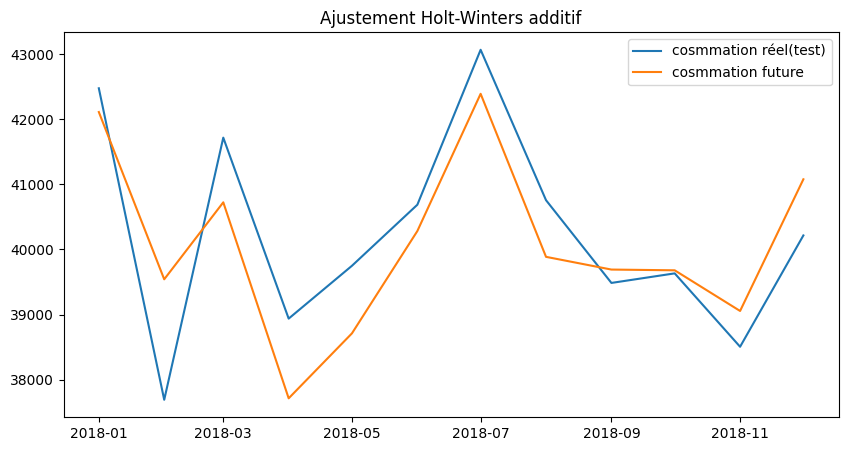

In [41]:
# √©valuation de mod√©le
y_pred_hw = fit_hw.forecast(len(y_test))

plt.figure(figsize=(10,5))
plt.plot(y_test , label="cosmmation r√©el(test)")
plt.plot(y_pred_hw, label="cosmmation future")
plt.title("Ajustement Holt-Winters additif")
plt.legend()
plt.show()

In [42]:


# MAE et RMSE
mae = mean_absolute_error(y_test, y_pred_hw)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_hw))
print(f"MAE : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")

# R2
r2 = r2_score(y_test, y_pred_hw)
print(f"R¬≤ : {r2:.3f}")

# AIC (depuis le mod√®le ajust√©)
# Supposons que hw_fit est le mod√®le Holt-Winters ajust√© avec .fit()
aic = fit_hw.aic
print(f"AIC : {aic:.2f}")


MAE : 757.39
RMSE : 894.15
R¬≤ : 0.658
AIC : 993.16


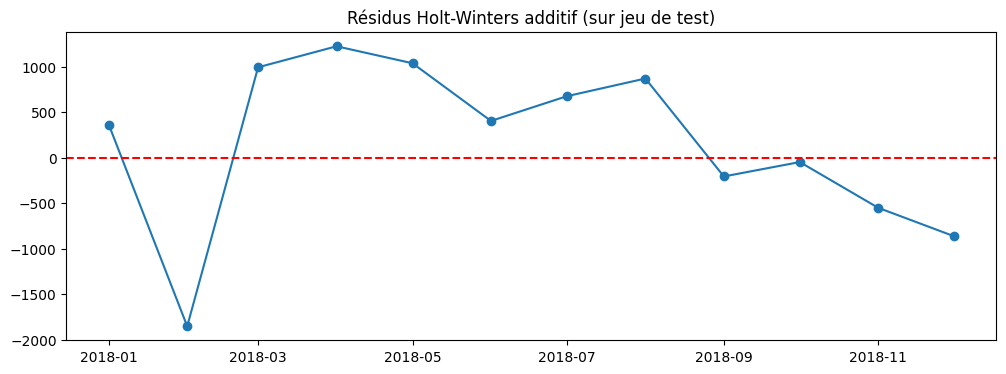

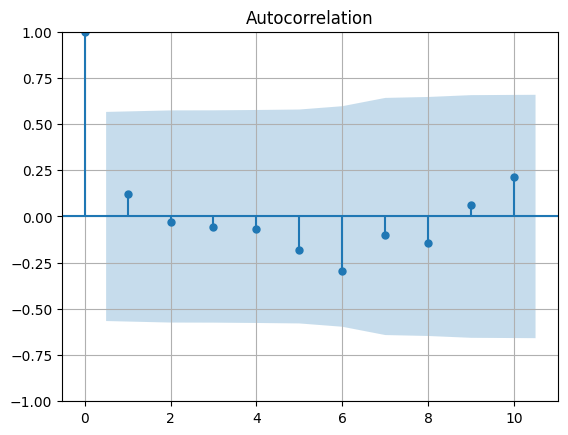

In [43]:
# analyse de r√©sidue


# R√©sidus uniquement sur la p√©riode test
residuals = y_test - y_pred_hw

# Trac√© des r√©sidus
plt.figure(figsize=(12,4))
plt.plot(residuals, marker="o")
plt.axhline(0, color="red", linestyle="--")
plt.title("R√©sidus Holt-Winters additif (sur jeu de test)")
plt.show()

# ACF des r√©sidus
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(residuals.dropna(), lags=10)
plt.grid(True)
plt.show()

Commentaire :

# Pr√©vision √† l'aide d'un mod√®le ARIMA saisonnier : SARIMA(p,d,q)(P,D,Q)_s

## √âtapes cl√©s

1. **Identifier la saisonnalit√©**
   - Analyser les autocorr√©logrammes (ACF, PACF) pour d√©tecter la p√©riode saisonni√®re `s`.
   - Observer les motifs r√©currents et d√©terminer la longueur de la saison (ex. 12 pour une saison mensuelle).

2. **Stationnariser la s√©rie temporelle**
   - V√©rifier si la s√©rie pr√©sente une tendance ou une saisonnalit√©.
   - Appliquer la **diff√©renciation non saisonni√®re** (`d`) pour supprimer la tendance.
   - Appliquer la **diff√©renciation saisonni√®re** (`D`) pour supprimer la saisonnalit√©.

3. **Identifier les ordres plausibles**
   - Examiner les autocorr√©logrammes et partial autocorr√©logrammes pour choisir des valeurs initiales :
     - `p, q` : composantes non saisonni√®res AR et MA
     - `P, Q` : composantes saisonni√®res AR et MA
   - La saisonnalit√© `s` doit √™tre pr√©cis√©e.

4. **Estimer les param√®tres du mod√®le**
   - Ajuster plusieurs mod√®les SARIMA avec diff√©rentes combinaisons d‚Äôordres plausibles.
   - Comparer les mod√®les √† l‚Äôaide de crit√®res comme **AIC** ou **BIC** pour choisir le mod√®le optimal.

5. **Valider le mod√®le**
   - Examiner les **r√©sidus** : ils doivent √™tre al√©atoires, sans tendance ni autocorr√©lation.
   - Utiliser des tests statistiques (ex. test de Ljung-Box) et visualiser les r√©sidus (ACF, histogramme, Q-Q plot).

6. **Pr√©visions et √©valuation**
   - G√©n√©rer les pr√©visions √† court et moyen terme.
   - Comparer les pr√©visions avec les donn√©es r√©elles et calculer des m√©triques de performance (MAE, RMSE, R¬≤).
   - Ajuster les param√®tres si n√©cessaire et r√©p√©ter le processus.

7. **Documentation et interpr√©tation**
   - Interpr√©ter la signification des composantes saisonni√®res et non saisonni√®res.
   - V√©rifier que le mod√®le capture bien la saisonnalit√© et les tendances observ√©es dans la s√©rie.


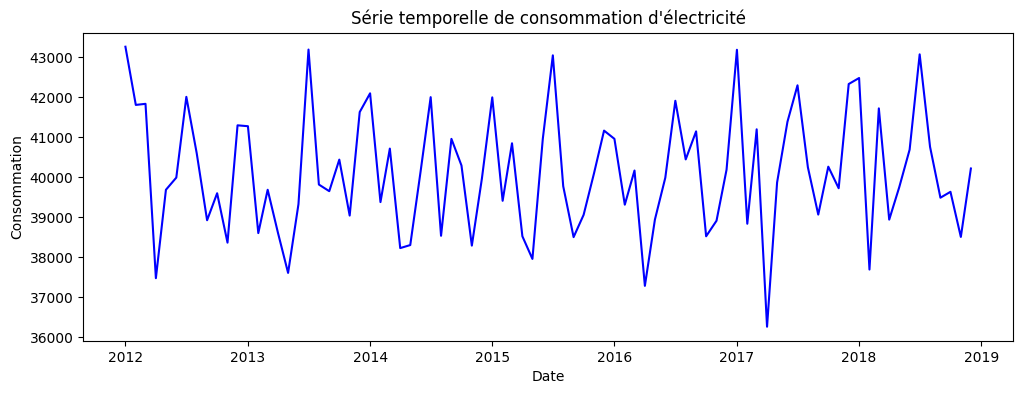

<Figure size 1200x400 with 0 Axes>

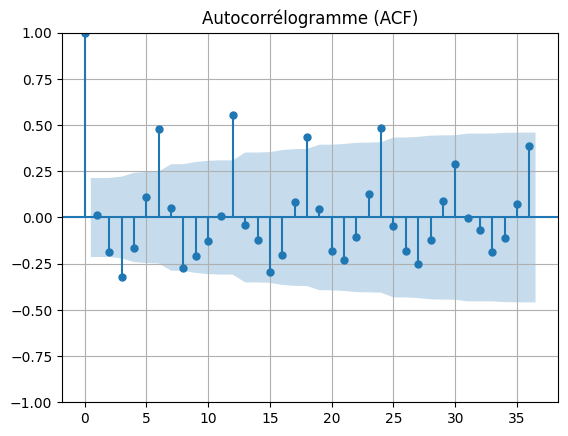

<Figure size 1200x400 with 0 Axes>

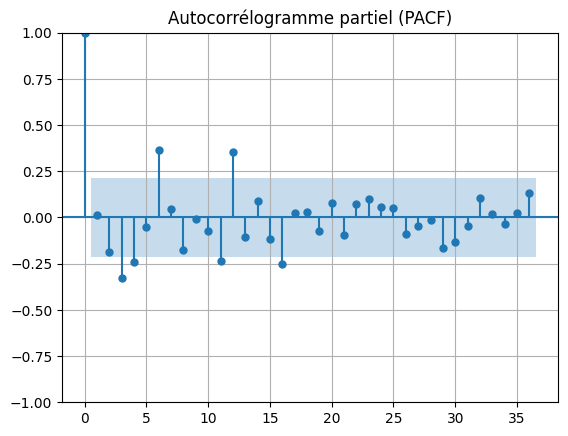

In [44]:

# Visualiser la s√©rie temporelle
plt.figure(figsize=(12, 4))
plt.plot(df['conso_corr'], color='blue')
plt.title("S√©rie temporelle de consommation d'√©lectricit√©")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.show()

# Tracer l'ACF (autocorr√©lation)
plt.figure(figsize=(12, 4))
plot_acf(df['conso_corr'], lags=36)  # lags = nombre de points de retard √† afficher
plt.title("Autocorr√©logramme (ACF)")
plt.grid()
plt.show()

# Tracer le PACF (autocorr√©lation partielle)
plt.figure(figsize=(12, 4))
plot_pacf(df['conso_corr'], lags=36, method='ywm')  # m√©thode 'ywm' pour stabilit√©
plt.title("Autocorr√©logramme partiel (PACF)")
plt.grid()
plt.show()


Hypoth√®ses du test ADF :

H0: La s√©rie n‚Äôest pas stationnaire (pr√©sence de racine unitaire)

H1: La s√©rie est stationnaire

In [45]:
#Stationnarit√©

from statsmodels.tsa.stattools import adfuller

result=adfuller(df["conso_corr"])
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])

data_diff1 = df['conso_corr'] - df['conso_corr'].shift(1)
data_diff1 = data_diff1[1:]  # supprimer le NaN initial

ADF Statistic: -2.181239
p-value: 0.213125


In [46]:
result=adfuller(data_diff1)
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])

ADF Statistic: -5.084842
p-value: 0.000015


In [47]:
from statsmodels.tsa.stattools import adfuller, kpss

def test_stationarity(series):
    adf_p, kpss_p = None, None
    try:
        adf_p = adfuller(series)[1]
    except:
        adf_p = float('nan')
    try:
        kpss_p = kpss(series, regression='c', nlags="auto")[1]
    except:
        kpss_p = float('nan')
    return adf_p, kpss_p

series = df['conso_corr']
max_diff = 3  # tester jusqu'√† 3 diff√©renciations

for d in range(max_diff+1):
    diff_series = series.diff(d).dropna()
    if diff_series.nunique() <= 1:
        print(f"d={d} --> S√©rie constante apr√®s diff√©renciation, tests ignor√©s")
        continue
    adf_p, kpss_p = test_stationarity(diff_series)
    print(f"d={d} --> ADF p-value: {adf_p:.4f}, KPSS p-value: {kpss_p:.4f}")

d=0 --> S√©rie constante apr√®s diff√©renciation, tests ignor√©s
d=1 --> ADF p-value: 0.0000, KPSS p-value: 0.1000
d=2 --> ADF p-value: 0.0000, KPSS p-value: 0.1000
d=3 --> ADF p-value: 0.0250, KPSS p-value: 0.1000


/tmp/ipython-input-443479334.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p = kpss(series, regression='c', nlags="auto")[1]
/tmp/ipython-input-443479334.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p = kpss(series, regression='c', nlags="auto")[1]
/tmp/ipython-input-443479334.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p = kpss(series, regression='c', nlags="auto")[1]


In [48]:
data_diff1 = df['conso_corr'] - df['conso_corr'].shift(1)
data_diff1 = data_diff1[1:]  # supprimer le NaN initial

In [49]:


# Fonction pour calculer MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # √âviter division par z√©ro
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Fonction pour rechercher le meilleur SARIMA
def sarima_grid_search(y,
                       p_values, d_values, q_values,
                       P_values, D_values, Q_values, s):
    results_list = []

    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            try:
                                model = SARIMAX(y,
                                                order=(p,d,q),
                                                seasonal_order=(P,D,Q,s),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                                res = model.fit(disp=False)

                                pred = res.fittedvalues

                                mse = mean_squared_error(y, pred)
                                rmse = np.sqrt(mse)
                                mae = mean_absolute_error(y, pred)
                                mape = mean_absolute_percentage_error(y, pred)
                                aic = res.aic

                                results_list.append({
                                    'p': p, 'd': d, 'q': q,
                                    'P': P, 'D': D, 'Q': Q,
                                    's': s,
                                    'AIC': aic,
                                    'MSE': mse,
                                    'RMSE': rmse,
                                    'MAE': mae,
                                    'MAPE': mape
                                })
                            except Exception as e:
                                # Afficher l'erreur si n√©cessaire
                                # print(f"Erreur pour {(p,d,q,P,D,Q,s)}: {e}")
                                continue

    results_df = pd.DataFrame(results_list)
    if not results_df.empty:
        best_model = results_df.sort_values('AIC').iloc[0]
        print("Meilleur mod√®le selon AIC :")
        print(best_model)
    else:
        print("Aucun mod√®le valide trouv√©.")

    return results_df

# Exemple d'utilisation
p_values = [0,1,2]
d_values = [0,1]
q_values = [0,1,2]
P_values = [0,1]
D_values = [0,1]
Q_values = [0,1]
s = 12  # saisonnalit√© (mensuelle)

# Supposons que votre s√©rie temporelle s'appelle y
results_df = sarima_grid_search(y, p_values, d_values, q_values, P_values, D_values, Q_values, s)

# Afficher le tableau complet tri√© par AIC
results_df.sort_values('AIC')

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

Meilleur mod√®le selon AIC :
p       2.000000e+00
d       1.000000e+00
q       2.000000e+00
P       0.000000e+00
D       1.000000e+00
Q       1.000000e+00
s       1.200000e+01
AIC     9.370402e+02
MSE     3.474408e+07
RMSE    5.894411e+03
MAE     2.012813e+03
MAPE    4.906885e+00
Name: 139, dtype: float64


p  d  q  P  D  Q   s           AIC           MSE          RMSE  \
139  2  1  2  0  1  1  12    937.040190  3.474408e+07  5.894411e+03   
91   1  1  2  0  1  1  12    939.863664  3.483768e+07  5.902346e+03   
43   0  1  2  0  1  1  12    940.143541  3.467786e+07  5.888791e+03   
143  2  1  2  1  1  1  12    945.254871  3.409258e+07  5.838885e+03   
95   1  1  2  1  1  1  12    946.493244  3.388151e+07  5.820783e+03   
..  .. .. .. .. .. ..  ..           ...           ...           ...   
16   0  0  2  0  0  0  12   1881.497296  2.340751e+08  1.529951e+04   
8    0  0  1  0  0  0  12   1916.747885  4.994645e+08  2.234870e+04   
0    0  0  0  0  0  0  12   1996.997433  1.611100e+09  4.013851e+04   
9    0  0  1  0  0  1  12  19351.420087  5.454822e+14  2.335556e+07   
17   0  0  2  0  0  1  12  20985.438708  2.780975e+16  1.667626e+08   

              MAE           MAPE  
139  2.012813e+03       4.906885  
91   2.063289e+03       5.027030  
43   1.961210e+03       4.787100  
143  2.224102e+03       5.448149  
95   2.159874e+03       5.284767  
..            ...            ...  
16   1.354060e+04      33.642722  
8    2.133254e+04      53.073268  
0    4.010973e+04     100.000000  
9    1.597552e+07   39771.344895  
17   6.486514e+07  161713.585003  

[144 rows x 12 columns]

In [50]:
# model SARIMA

model_sarima=SARIMAX(
              y_train,
              order=(2,1,2),
              seasonal_order=(0,1,1,12),
              enforce_stationarity=False,                              #Permet d'estimer le mod√®le m√™me si la s√©rie n'est pas stationnaire
              enforce_invertibility=False                              #Permet d'estimer le mod√®le m√™me si les conditions d'inversibilit√©
              )

results_sarima=model_sarima.fit()
print(results_sarima.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                           conso_corr   No. Observations:                   72
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -363.646
Date:                              Tue, 16 Sep 2025   AIC                            739.293
Time:                                      16:20:58   BIC                            749.998
Sample:                                  01-01-2012   HQIC                           743.263
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1761      0.310      0.568      0.570      -0.431       0.783
ar.L2         -0.29

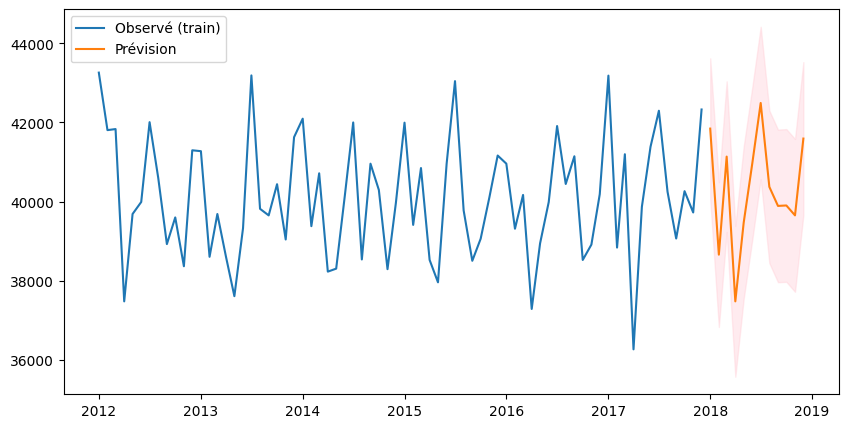

In [51]:
y_pred_sarima = results_sarima.get_forecast(steps=12)
pred_mean = y_pred_sarima.predicted_mean
conf_int = y_pred_sarima.conf_int()

plt.figure(figsize=(10,5))
plt.plot(y_train, label='Observ√© (train)')
plt.plot(pred_mean, label='Pr√©vision')
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='pink', alpha=0.3)
plt.legend()
plt.show()

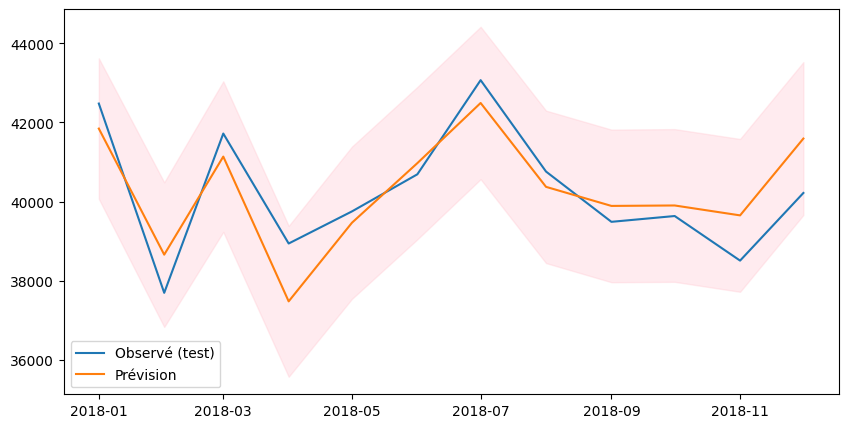

In [52]:
plt.figure(figsize=(10,5))
plt.plot(y_test, label='Observ√© (test)')
plt.plot(pred_mean, label='Pr√©vision')
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='pink', alpha=0.3)
plt.legend()
plt.show()

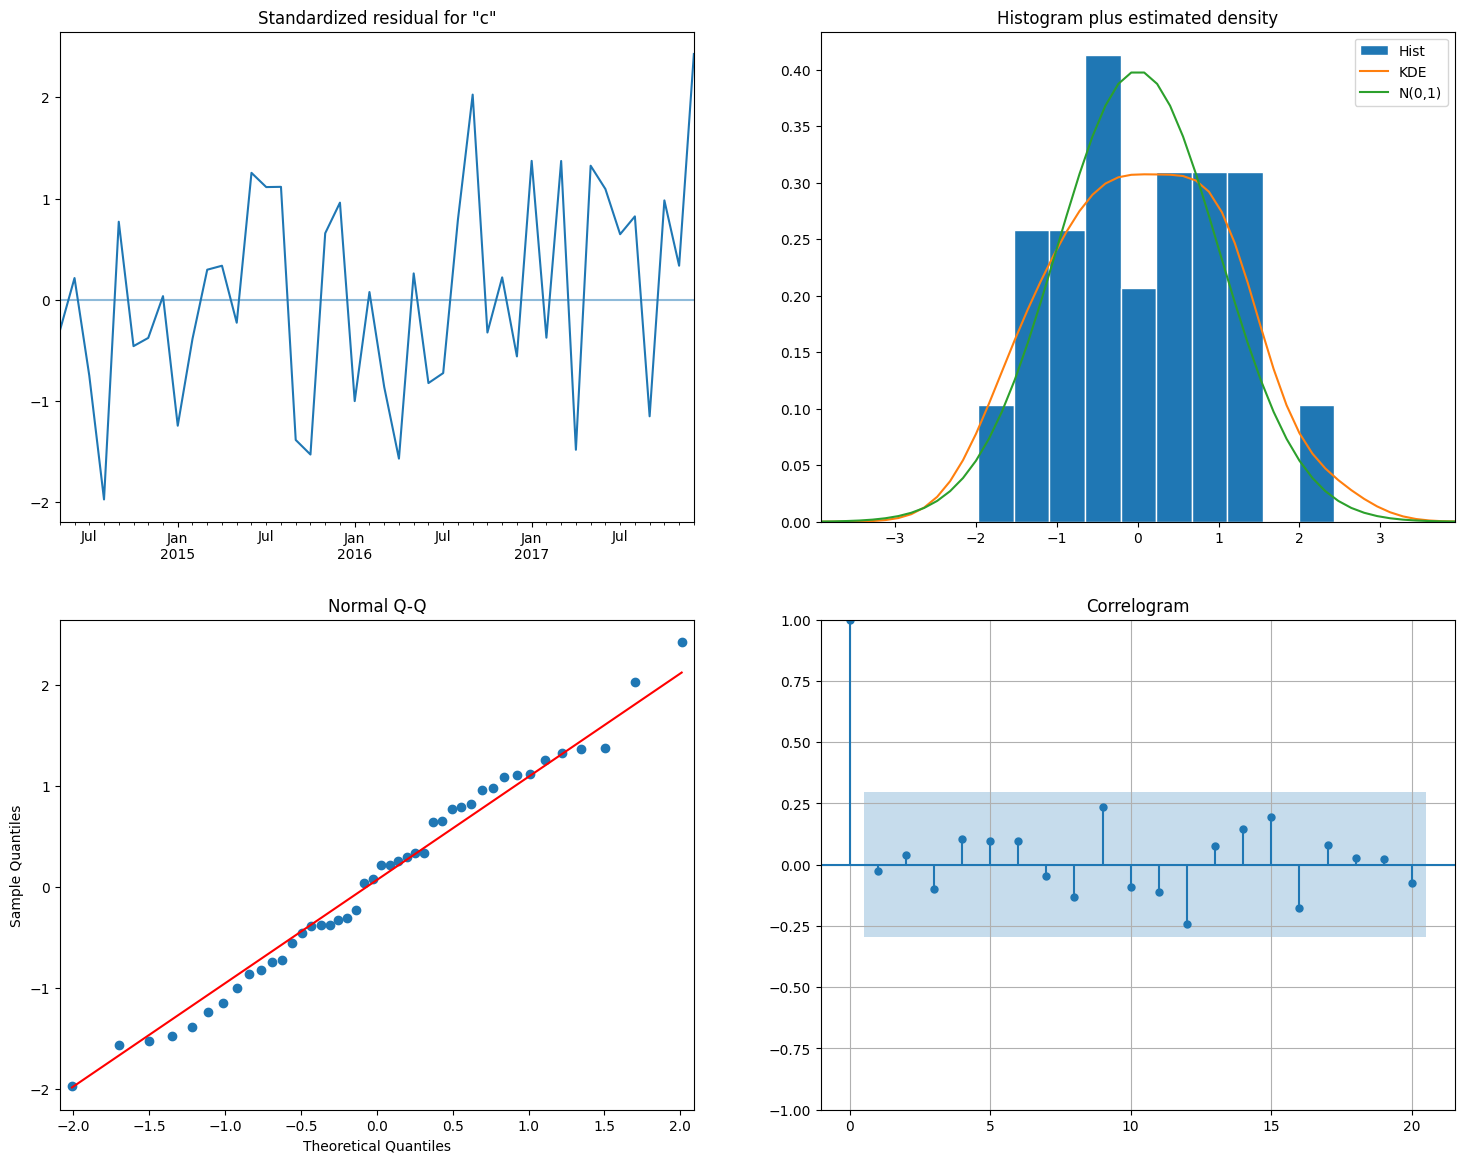

In [53]:
def plot_diagnostics(sarima_res, variable=0, lags=10, fig=None, figsize=None):
        return type(sarima_res.plot_diagnostics(variable, lags, fig, figsize))


plot_diagnostics(sarima_res = results_sarima, figsize=(18,14), lags=20)
plt.grid(True)

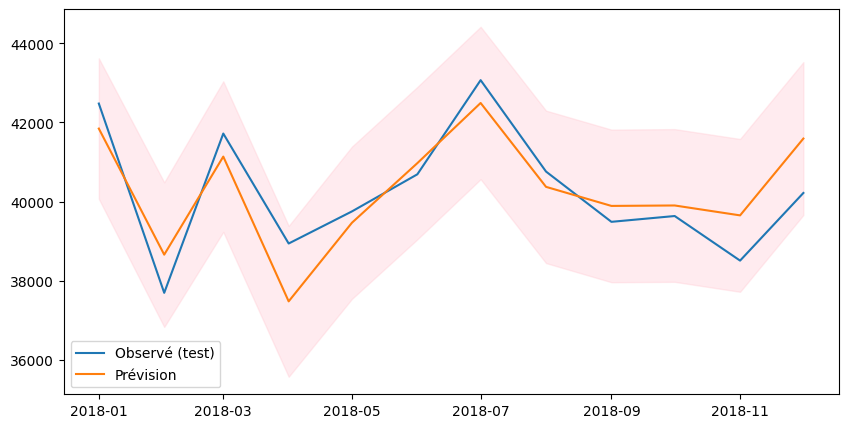

In [54]:
forecast = results_sarima.get_forecast(steps=12)
pred_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

plt.figure(figsize=(10,5))
plt.plot(y_test, label='Observ√© (test)')
plt.plot(pred_mean, label='Pr√©vision')
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='pink', alpha=0.3)
plt.legend()
plt.show()

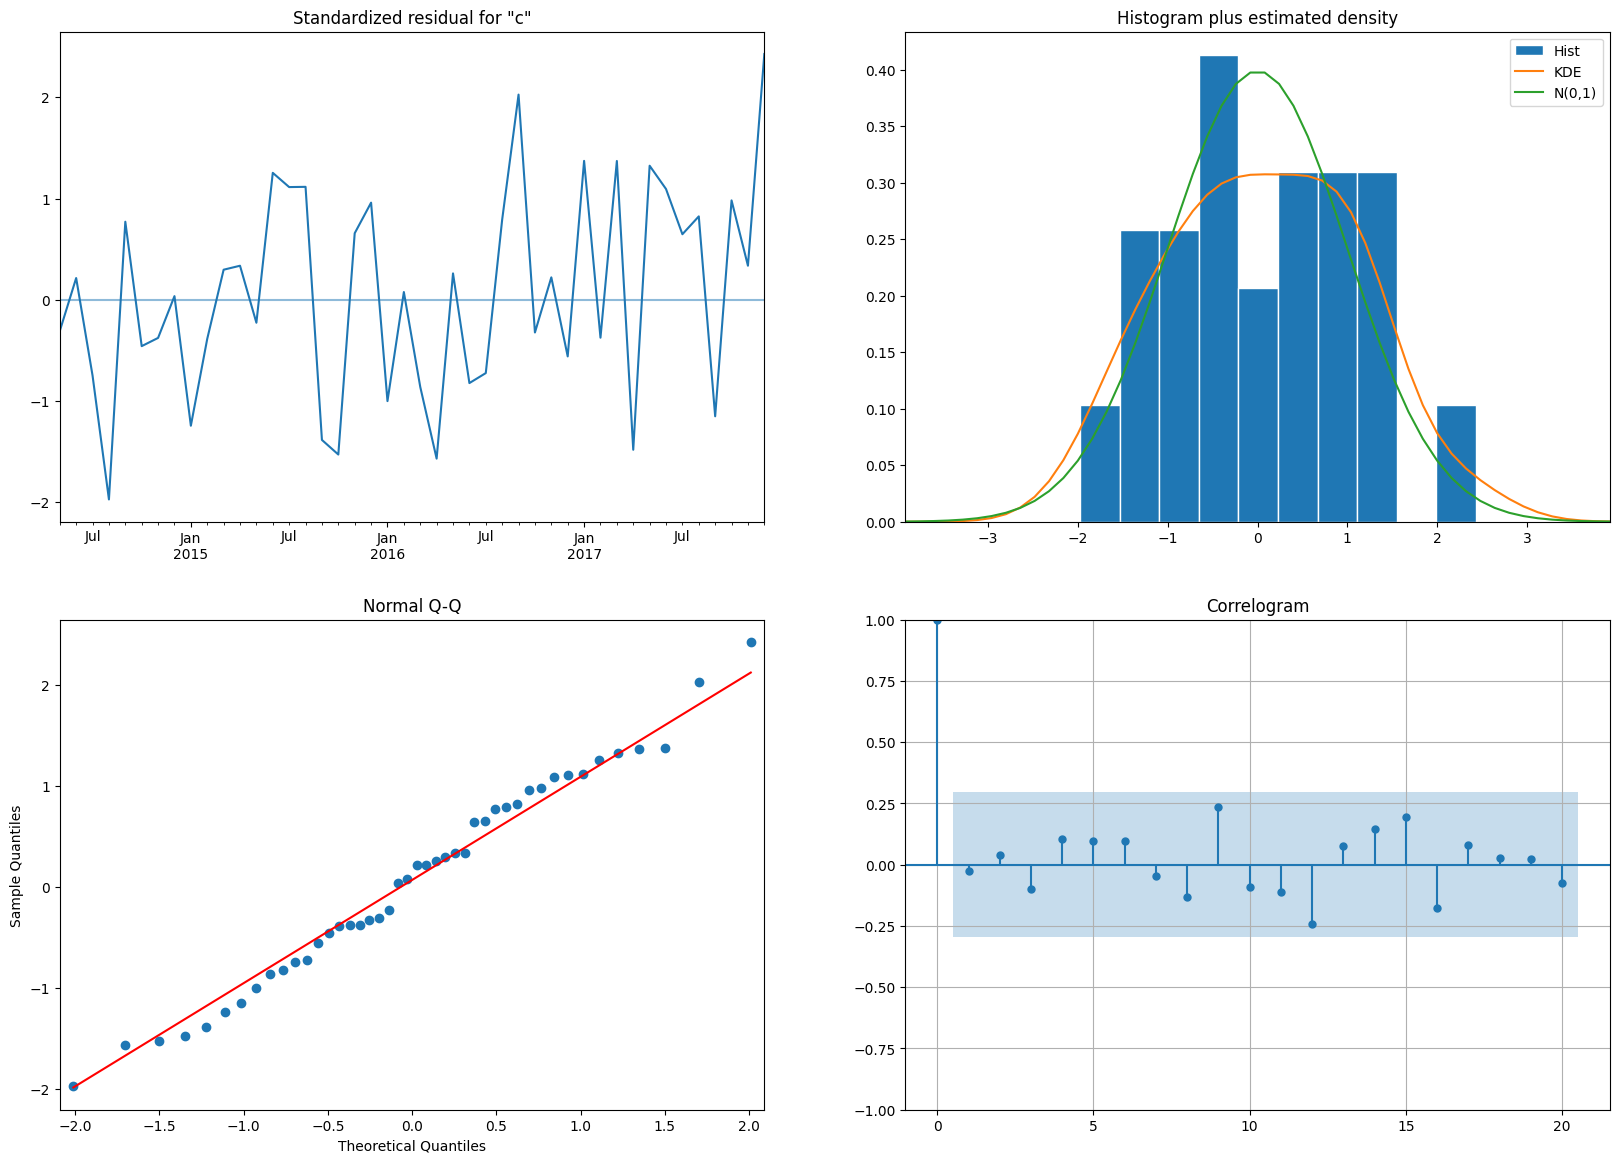

In [55]:
def plot_diagnostics(sarima_res, variable=0, lags=10, fig=None, figsize=None):
        return type(sarima_res.plot_diagnostics(variable, lags, fig, figsize))


plot_diagnostics(sarima_res =results_sarima, figsize=(20,14), lags=20)
plt.grid(True)


In [56]:

# Pr√©visions : 12 derni√®res valeurs
y_hw = np.array(y_pred_hw[-12:])                 # Holt-Winters
y_sarima = np.array(y_pred_sarima.predicted_mean[-12:])  # SARIMA

# Vraies valeurs du test
y_true = np.array(y_test)

# Fonction pour calculer les m√©triques
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred)/y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return [mae, mse, rmse, mape, r2]

# Calcul des m√©triques
metrics_hw = calculate_metrics(y_true, y_hw)
metrics_sarima = calculate_metrics(y_true, y_sarima)

# Cr√©er le tableau comparatif
metrics_names = ['MAE', 'MSE', 'RMSE', 'MAPE (%)', 'R¬≤']
comparison_df = pd.DataFrame({
    'M√©trique': metrics_names,
    'Holt-Winters': metrics_hw,
    'SARIMA': metrics_sarima
})

# Afficher le tableau
print(comparison_df)


   M√©trique   Holt-Winters         SARIMA
0       MAE     757.393420     697.078193
1       MSE  799510.982267  657467.458066
2      RMSE     894.153780     810.843671
3  MAPE (%)       1.901761       1.749265
4        R¬≤       0.657812       0.718606


# üìä √âtapes de mise en ≈ìuvre d‚Äôun mod√®le SARIMAX

## 1. Analyse exploratoire
- Visualiser la s√©rie pour d√©tecter **tendance, saisonnalit√©, volatilit√©**.  
- Calculer les **fonctions d‚Äôautocorr√©lation (ACF)** et **autocorr√©lation partielle (PACF)** pour identifier les ordres potentiels *(p, q)*.  
- V√©rifier la **stationnarit√©** de la s√©rie avec des tests statistiques comme **ADF** ou **KPSS**.  

## 2. D√©terminer les param√®tres
- Choisir les param√®tres **(p, d, q)** pour la partie ARIMA.  
- D√©terminer les param√®tres saisonniers **(P, D, Q, s)** pour capturer les effets p√©riodiques.  
- Inclure les **variables exog√®nes** (si disponibles) afin d‚Äôam√©liorer les pr√©visions.  

## 3. Estimer le mod√®le SARIMAX
- Ajuster le mod√®le en utilisant les param√®tres choisis.  
- V√©rifier la **convergence** de l‚Äôalgorithme d‚Äôoptimisation pour s‚Äôassurer que le mod√®le a bien √©t√© estim√©.  

## 4. √âvaluer le mod√®le
- Analyser les **r√©sidus** (autocorr√©lation, normalit√©).  
- Calculer les m√©triques d‚Äôerreur : **MAE**, **RMSE**, et les crit√®res d‚Äôinformation (**AIC**, **BIC**).  
- Ajuster les param√®tres si n√©cessaire (approche it√©rative).  

## 5. Produire les pr√©visions
- G√©n√©rer des **pr√©visions** sur la p√©riode cible.  
- Visualiser les **pr√©dictions** et leurs **intervalles de confiance**.  

## 6. Valider et interpr√©ter
- Comparer les pr√©visions avec les **valeurs r√©elles** sur un jeu de test.  
- Interpr√©ter l‚Äô**impact des variables exog√®nes** sur les pr√©visions.  

## 7 D√©ployer et automatiser
- Mettre le mod√®le en **production** dans un pipeline de pr√©vision.  
- Surveiller les **performances** et **r√©entra√Æner** r√©guli√®rement si n√©cessaire.  


In [57]:
df_consomation_fr=pd.read_csv("consomation_fr.csv")

In [58]:
df_consomation_fr=df_consomation_fr.drop(columns=["Territoire","Consommation totale"])
df_consomation_fr.head(2)

Mois  Production totale  Production nucl√©aire  \
0  2012-01-01              57177               42811.0   
1  2012-02-01              54419               38661.0   

   Production thermique totale  Production thermique charbon  \
0                         5399                         741.0   
1                         8721                        2511.0   

   Production thermique fioul  Production thermique gaz  \
0                         691                      3967   
1                        1309                      4901   

   Production hydraulique  Production √©olien  Production solaire  \
0                    6741               1587                 125   
1                    5244               1123                 216   

   Production bio√©nergies  
0                     514  
1                     454

In [59]:
df_consomation_fr.set_index("Mois" , inplace = True)
df_consomation_fr.index=pd.to_datetime(df_consomation_fr.index)

In [61]:
df_consomation_fr.head(2)

Production totale  Production nucl√©aire  \
Mois                                                  
2012-01-01              57177               42811.0   
2012-02-01              54419               38661.0   

            Production thermique totale  Production thermique charbon  \
Mois                                                                    
2012-01-01                         5399                         741.0   
2012-02-01                         8721                        2511.0   

            Production thermique fioul  Production thermique gaz  \
Mois                                                               
2012-01-01                         691                      3967   
2012-02-01                        1309                      4901   

            Production hydraulique  Production √©olien  Production solaire  \
Mois                                                                        
2012-01-01                    6741               1587                 125   
2012-02-01                    5244               1123                 216   

            Production bio√©nergies  
Mois                                
2012-01-01                     514  
2012-02-01                     454

In [62]:
df2 = pd.merge(df, df_consomation_fr, how='inner', on='Mois')
df2

dju_chauffage    conso_corr  Production totale  \
Mois                                                         
2012-01-01          336.0  43259.231509              57177   
2012-02-01          435.9  41804.889062              54419   
2012-03-01          201.9  41831.997497              48583   
2012-04-01          230.3  37474.827072              44192   
2012-05-01           83.3  39684.138781              40433   
...                   ...           ...                ...   
2018-08-01            3.3  40757.492092              37283   
2018-09-01           34.3  39486.242684              38868   
2018-10-01          122.4  39633.104850              42356   
2018-11-01          282.5  38505.549036              46318   
2018-12-01          325.9  40215.999865              53394   

            Production nucl√©aire  Production thermique totale  \
Mois                                                            
2012-01-01               42811.0                         5399   
2012-02-01               38661.0                         8721   
2012-03-01               37549.0                         5276   
2012-04-01               33100.0                         3484   
2012-05-01               29058.0                         1772   
...                          ...                          ...   
2018-08-01               27294.0                         2515   
2018-09-01               30099.0                         2144   
2018-10-01               31613.0                         3721   
2018-11-01               32658.0                         5600   
2018-12-01               38890.0                         4522   

            Production thermique charbon  Production thermique fioul  \
Mois                                                                   
2012-01-01                         741.0                         691   
2012-02-01                        2511.0                        1309   
2012-03-01                        1435.0                         666   
2012-04-01                        1655.0                         486   
2012-05-01                         854.0                         368   
...                                  ...                         ...   
2018-08-01                         502.0                         189   
2018-09-01                         348.0                         157   
2018-10-01                         793.0                         152   
2018-11-01                         503.0                         161   
2018-12-01                         218.0                         193   

            Production thermique gaz  Production hydraulique  \
Mois                                                           
2012-01-01                      3967                    6741   
2012-02-01                      4901                    5244   
2012-03-01                      3175                    3894   
2012-04-01                      1343                    5302   
2012-05-01                       549                    7706   
...                              ...                     ...   
2018-08-01                      1824                    3906   
2018-09-01                      1638                    3028   
2018-10-01                      2775                    2931   
2018-11-01                      4934                    3970   
2018-12-01                      4110                    5182   

            Production √©olien  Production solaire  Production bio√©nergies  
Mois                                                                       
2012-01-01               1587                 125                     514  
2012-02-01               1123                 216                     454  
2012-03-01                977                 356                     531  
2012-04-01               1572                 329                     405  
2012-05-01                974                 454                     469  
...                       ...                 ...     

In [64]:
# Variables cibles et exog√®nes
y2 = df2['conso_corr']
X = df2[[ 'dju_chauffage','Production totale', 'Production nucl√©aire',
       'Production thermique totale', 'Production thermique charbon',
       'Production thermique fioul', 'Production thermique gaz',
       'Production hydraulique', 'Production √©olien', 'Production solaire',
       'Production bio√©nergies']]  # exog√®ne(s) sous forme DataFrame

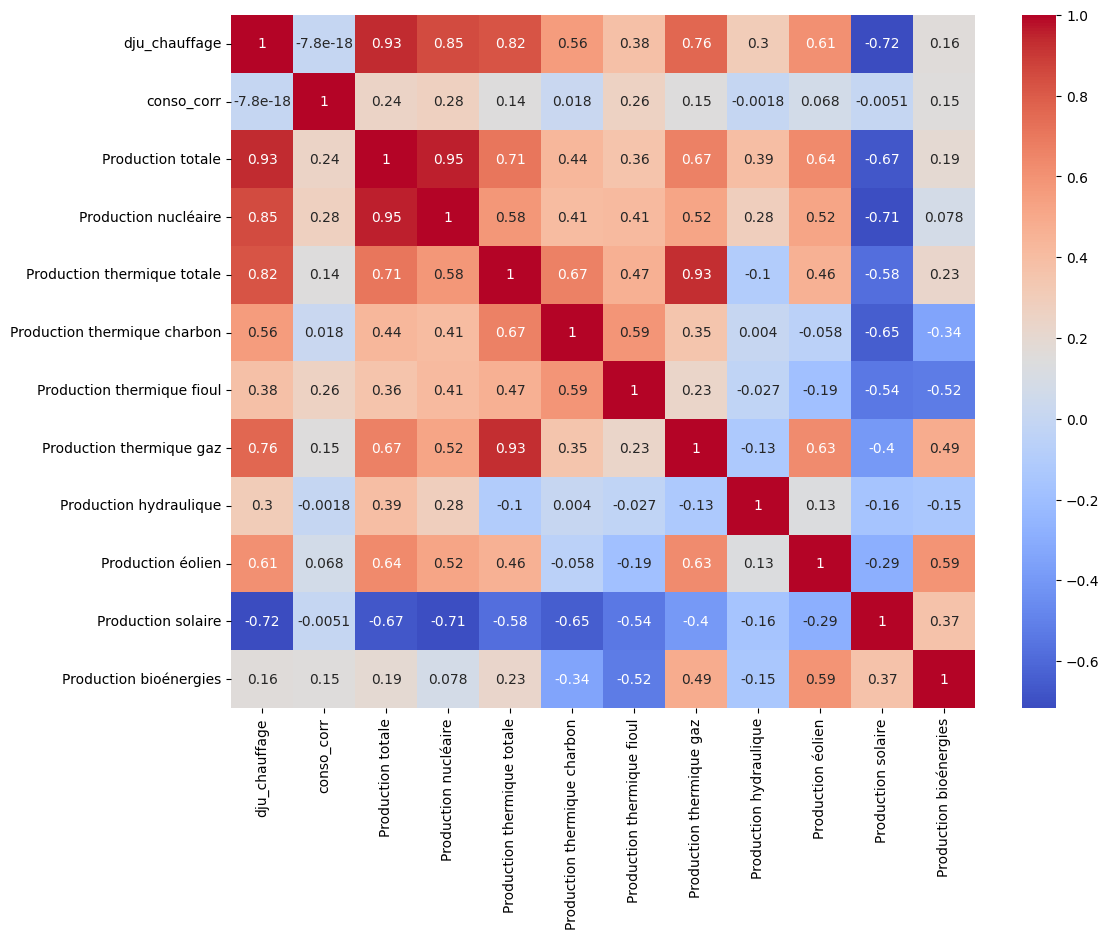

In [67]:
#### Tester l'ind√©pendance entre les variables
# Visualiser la corr√©lation
plt.figure(figsize=(12, 9))
corr_matrix = df2.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

D'apr√®s l'analyse de la matrice de corr√©lation (repr√©sent√©e par carte de chaleurs), les variables **Production totale, Production nucl√©aire, Production thermique totale et Production thermique gaz** ont √©t√© √©limin√©es en raison de leurs fortes corr√©lations avec d'autres variables, afin d'√©viter les probl√®mes de multicolin√©arit√© dans l'analyse en composantes principales (ACP).



In [69]:
df2.columns

Index(['dju_chauffage', 'conso_corr', 'Production totale',
       'Production nucl√©aire', 'Production thermique totale',
       'Production thermique charbon', 'Production thermique fioul',
       'Production thermique gaz', 'Production hydraulique',
       'Production √©olien', 'Production solaire', 'Production bio√©nergies'],
      dtype='object')

In [71]:
train_size = int(len(df2) * 0.8)

X_selected = df2[['dju_chauffage',
                  'Production thermique fioul',
                  'Production bio√©nergies',
                  'Production hydraulique',
                  'Production thermique charbon',
                  'Production solaire',
                  'Production √©olien'
                 ]]

X_selected_train2, X_selected_test2 = X_selected.iloc[:train_size], X_selected.iloc[train_size:]
y_train2, y_test2 = y2.iloc[:train_size], y2.iloc[train_size:]

In [72]:
print("Train y:", y_train2.shape)
print("Test y :", y_test2.shape)

print("Train x:", X_selected_train2.shape)
print("Test  x:", X_selected_test2.shape)

Train y: (67,)
Test y : (17,)
Train x: (67, 7)
Test  x: (17, 7)


In [74]:


p_values = [0,1]
d_values = [1]
q_values = [0,1]
P_values = [0,1]
D_values = [1]
Q_values = [0,1]
s = 12

best_aic = float('inf')
best_order = None
best_seasonal_order = None
best_model = None

for p,d,q in itertools.product(p_values,d_values,q_values):
    for P,D,Q in itertools.product(P_values,D_values,Q_values):
        try:
            model = sm.tsa.statespace.SARIMAX(y2, exog=X_selected,
                                              order=(p,d,q),
                                              seasonal_order=(P,D,Q,s),
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
            res = model.fit(disp=False)
            if res.aic < best_aic:
                best_aic = res.aic
                best_order = (p,d,q)
                best_seasonal_order = (P,D,Q,s)
                best_model = res
        except:
            continue

print("Meilleur mod√®le :")
print("Order:", best_order)
print("Seasonal Order:", best_seasonal_order)
print("AIC:", best_aic)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used

Meilleur mod√®le :
Order: (0, 1, 1)
Seasonal Order: (0, 1, 1, 12)
AIC: 947.4007033007406


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [75]:
model_sarimax = sm.tsa.SARIMAX(
    y_train2,
    exog=X_selected_train2,  # None si pas de variable externe
    order=(0,1,1),          # p,d,q
    seasonal_order=(0,1,1,12)  # P,D,Q,s
)

results_sarimax = model_sarimax.fit()
print(results_sarimax.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                         conso_corr   No. Observations:                   67
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -447.847
Date:                            Tue, 16 Sep 2025   AIC                            915.694
Time:                                    16:57:32   BIC                            935.583
Sample:                                01-01-2012   HQIC                           923.364
                                     - 07-01-2017                                         
Covariance Type:                              opg                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
dju_chauffage                  -19.7385      3.621     -5.451      0.000     -

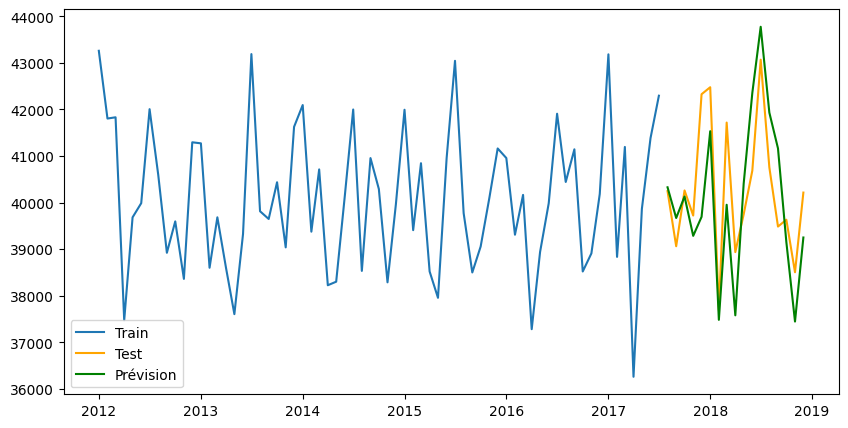

In [76]:
# Pr√©diction
y_pred_sarimax = results_sarimax.predict(
    start=len(y_train2),
    end=len(y_train2) + len(y_test2) - 1,
    exog=X_selected_test2
)

# Visualisation
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(y_train2, label="Train")
plt.plot(y_test2, label="Test", color="orange")
plt.plot(y_pred_sarimax , label="Pr√©vision", color="green")
plt.legend()
plt.show()

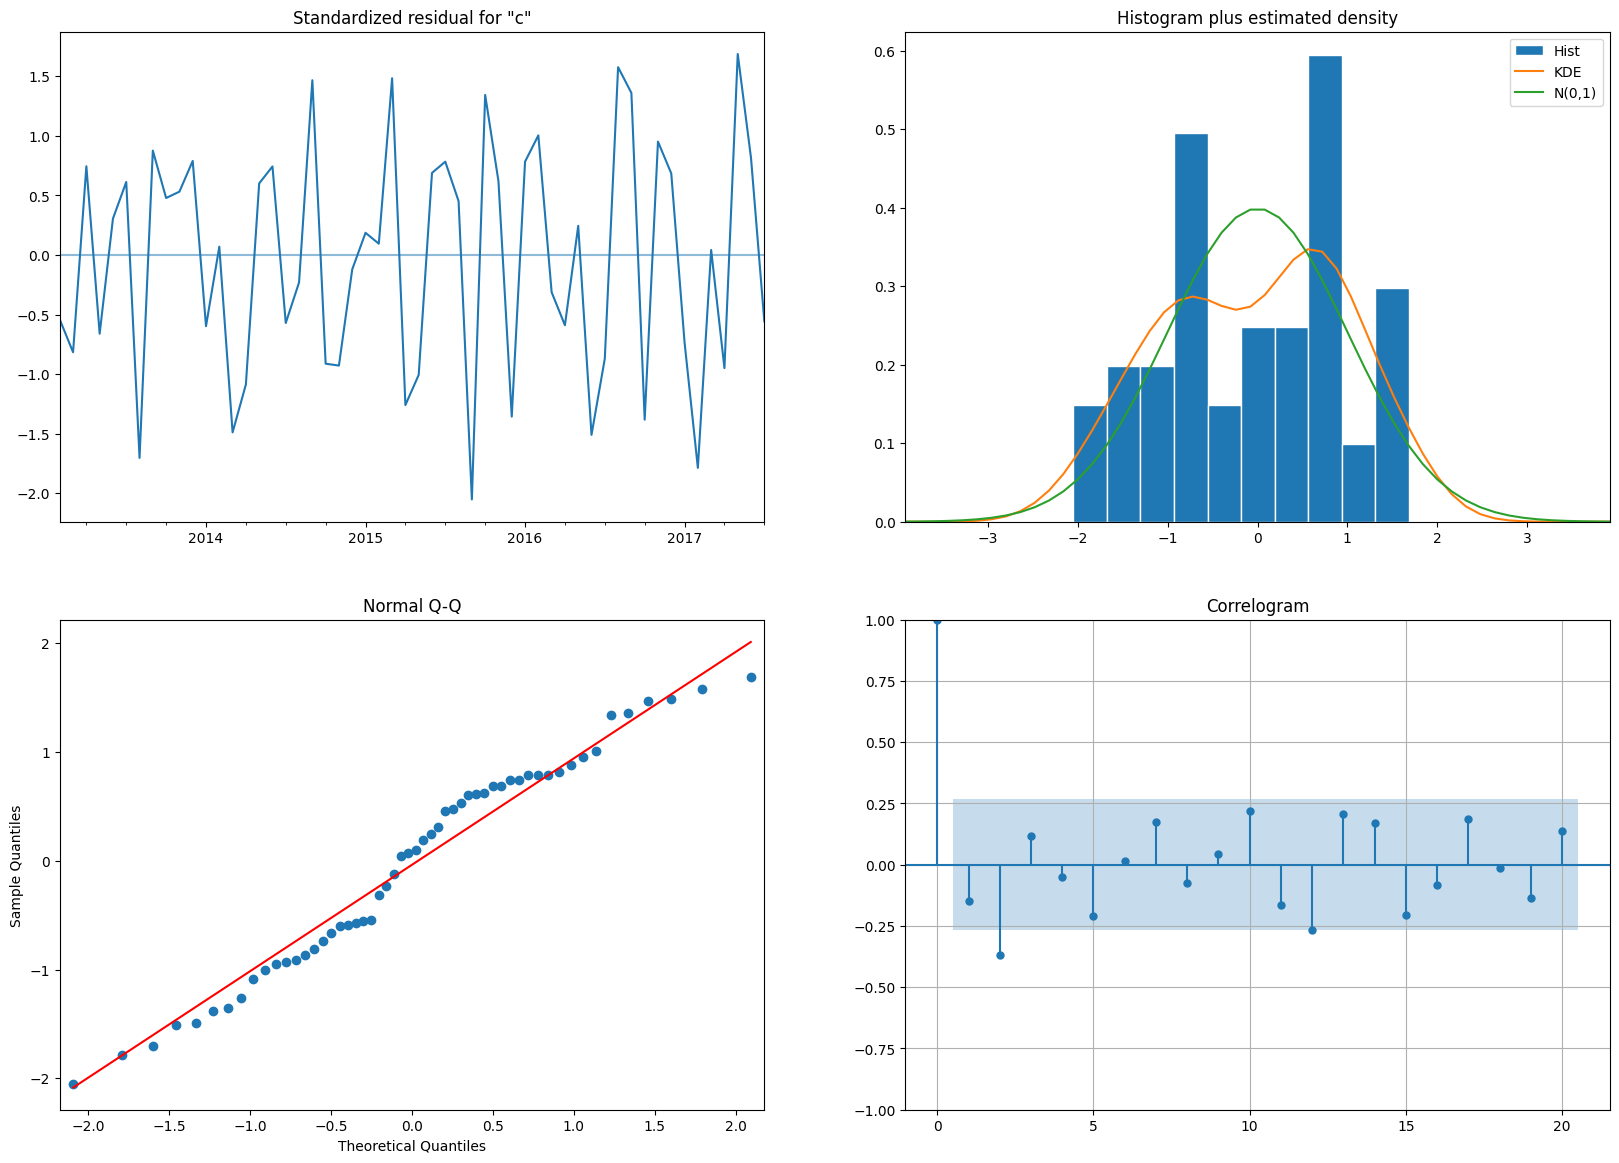

In [77]:
plot_diagnostics(sarima_res = results_sarimax, figsize=(20,14), lags=20)
plt.grid(True)

In [78]:
# S'assurer que y_test2 et y_pred_sarimax ont la m√™me longueur
y_true = y_test2
y_pred = y_pred_sarimax

# MAE
mae = mean_absolute_error(y_true, y_pred)

# MSE
mse = mean_squared_error(y_true, y_pred)

# RMSE
rmse = np.sqrt(mse)

# MAPE (%)
mask = y_true != 0  # √©viter division par z√©ro
mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# R¬≤
r2 = r2_score(y_true, y_pred)

# Affichage
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE (%): {mape:.2f}%")
print(f"R¬≤: {r2:.4f}")


MAE: 973.55
MSE: 1387929.82
RMSE: 1178.10
MAPE (%): 2.40%
R¬≤: 0.3067


# üìä Conclusion : Comparaison des mod√®les Holt-Winters et SARIMA

L'analyse des m√©triques de performance met en √©vidence que le mod√®le **SARIMA** surpasse le mod√®le **Holt-Winters** pour cette s√©rie temporelle :

- **MAE** et **RMSE** plus faibles ‚Üí pr√©visions plus proches des valeurs r√©elles.  
- **MSE** significativement r√©duit ‚Üí meilleure capture de la dynamique des donn√©es et r√©duction des erreurs importantes.  
- **MAPE** plus bas ‚Üí pr√©cision relative am√©lior√©e (erreurs en pourcentage plus faibles).  
- **R¬≤** plus √©lev√© ‚Üí SARIMA explique une part plus importante de la variance de la s√©rie, donc un meilleur ajustement global.  

‚úÖ **Conclusion** : Le mod√®le **SARIMA** est plus performant et fournit des pr√©visions plus pr√©cises et fiables.  
Il est donc recommand√© pour la mise en production et pour appuyer la prise de d√©cision sur cette s√©rie temporelle.
